In [37]:
import os 
import numpy as np
import pandas as pd
import torch
import pickle
from torch import nn
from torch.utils.data import *
import matplotlib.pyplot as plt
from torchvision.transforms import functional, Normalize, RandomRotation
from torch.optim import *
%matplotlib inline


In [38]:
root_path = '../datasets/cifar10/'
files = os.listdir(root_path)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [39]:
class ImageDataset(Dataset):
    ## transform and target_transform are specific to images.
    def __init__(self,root_path,is_train,mean_vec = None, transform=None, target_transform=None):
        self.root_path = root_path
        self.files = os.listdir(self.root_path)
        self.transform = transform
        self.target_transform = target_transform
        if is_train:
            self.x,self.y = self.read_train_data()
        else:
            self.x,self.y = self.read_test_data()
        
        if is_train:
            self.mean_vec = np.array([np.mean(self.x[:,0,:,:]),
                                      np.mean(self.x[:,1,:,:]),
                                      np.mean(self.x[:,2,:,:])])
        else:
            self.mean_vec = mean_vec
            
        self.std_vec = np.array([1.0,1.0,1.0])
        
        self.x = Normalize(self.mean_vec,self.std_vec)(torch.from_numpy(self.x))
        '''
        if is_train:
            self.x = self.augmentation()
            self.y = np.concatenate((self.y,self.y))
        '''
        
    def read_data_batch(self,file_name):
        with open(file_name,'rb') as f:
            dict_data = pickle.load(f,encoding='latin1')
        return dict_data
    
    def read_train_data(self):
        #x = np.empty((0,3072),dtype=np.float32)
        x = np.empty((0,3072),dtype=np.uint8)
        y = []
        data_size = 0
        for f in self.files[1:-1]:
            train_batch = self.read_data_batch(os.path.join(self.root_path,f))
            #x = np.concatenate((x,train_batch['data']/np.float32(255)))
            x = np.concatenate((x,train_batch['data']))/np.float32(1)
            y.extend(train_batch['labels'])
        data_size = x.shape[0]
        x = x.reshape(data_size,3,32,32)
        return x,np.array(y)
    
    def read_test_data(self):
        data_size = 0
        test_batch = self.read_data_batch(os.path.join(self.root_path,self.files[-1]))
        x = test_batch['data']/np.float32(1)
        y = test_batch['labels']
        data_size = x.shape[0]
        x = x.reshape(data_size,3,32,32)
        return x,np.array(y)
        
    def augmentation(self):
        num_images = self.x.size(0)
        rotater = RandomRotation((0,180))
        rotated_imgs = rotater(self.x)#torch.tensor([rotater(i) for i in self.x])
        return torch.cat((self.x,rotated_imgs))
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self,idx):
        return self.x[idx,:,:,:], self.y[idx]
    
   # .to_tensor


In [40]:
train_dataset = ImageDataset(root_path, is_train = True)
test_dataset = ImageDataset(root_path, mean_vec = train_dataset.mean_vec, is_train = False)
train_dataloader = DataLoader(train_dataset, batch_size = 128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle=True)

In [41]:
class Resnet_Block(nn.Module):
    def __init__(self, in_channels=32, out_channels=32):
        super(Resnet_Block,self).__init__()
        self.reset_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels), 
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),)
    
    def forward(self,x):
        return self.reset_block(x)
            

class customCNN2(nn.Module):
    def __init__(self):
        super(customCNN2,self).__init__()
        self.conv_pool_input_stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32), # 32,32,32 -C,H,W
            nn.MaxPool2d(kernel_size=(3,3),stride=1,padding=1,dilation=1),
            nn.Conv2d(32, 64, kernel_size=(1,1), stride=1, padding=0),)
        
        self.reset_block1 = Resnet_Block(in_channels=64, out_channels=64).to(device)
        # 32,32,64 - H,W,C
        # Add x here
        self.relu_after_resnet1 = nn.ReLU()
        
        """
        self.reset_block2 = Resnet_Block(in_channels=64, out_channels=64).to(device)
        # Add x here
        self.relu_after_resnet2 = nn.ReLU()
        """
        
        self.conv_after_resnet = nn.Sequential(
            nn.Conv2d(64, 16, kernel_size=(3,3), stride=1, padding=1),
            
            nn.ReLU(),# 128,32,32 -C,H,W
            nn.BatchNorm2d(16), # 64,16,16
            nn.MaxPool2d(kernel_size=(4,4),stride=2,padding=1,dilation=1),)
        
        self.final_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*16*16, 512),
            nn.ReLU(),
            nn.Linear( 512,10),
        )

        
    def forward(self,x):
        prep_input = self.conv_pool_input_stack(x)
        resnet1_output = self.reset_block1(prep_input)
        resnet1_relu_output = self.relu_after_resnet1 (resnet1_output+prep_input)
        #resnet2_output = self.reset_block2(resnet1_relu_output)
        #resnet2_relu_output = self.relu_after_resnet2 (resnet2_output+resnet1_relu_output)
        ######conv_after_resnet_output = self.conv_after_resnet(resnet2_relu_output)
        conv_after_resnet_output = self.conv_after_resnet(resnet1_relu_output)
        logits = self.final_fc(conv_after_resnet_output)
        return logits

In [42]:

def train(model, optimizer, loss_fn, train_dataloader,train_loss):
    model.train()
    for batch, (x_train,y_train) in enumerate(train_dataloader):
        x_train = x_train.cuda()
        x_train.to(device)
        y_train = y_train.cuda()
        y_train.to(device)
        #x_train = torch.from_numpy(x_train).float().to(device)
        logits = model(x_train)
        # model.to(device)
        loss_val = loss_fn(logits, y_train)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if batch%100==0:
            print("Batch Loss: ", loss_val.item())
            train_loss.append(loss_val.item())
    return model, train_loss

def test(model, test_dataloader,loss_fn,test_loss,test_acc):
    model.eval()
    total_loss = 0
    total_acc = 0
    num_batches = len(test_dataloader)
    with torch.no_grad():
        for x_test, y_test in test_dataloader:
            x_test = x_test.cuda()
            y_test = y_test.cuda()
            logits = model(x_test)
            loss_val = loss_fn(logits, y_test)
            total_loss += loss_val
            total_acc += (logits.argmax(1)==y_test).type(torch.float).sum().item()
    print("Batch Loss Val: ", total_loss.item()/num_batches)
    
    print("Accuracy: ", total_acc)
    test_loss.append(total_loss.item())
    test_acc.append(total_acc)
    return test_loss,test_acc

In [43]:
model = customCNN2().to(device)
loss_fn = nn.CrossEntropyLoss()
#optimizer = Adam(model.parameters(),lr=0.0008,weight_decay=0.02)
optimizer = Adam(model.parameters(),lr=0.00088,weight_decay=0.0042)
print(device)

cuda


In [44]:
epochs = 30
train_loss = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    print("Epoch: ", epoch)
    model,train_loss = train(model, optimizer, loss_fn, train_dataloader,train_loss)
    test_loss,test_acc = test(model, test_dataloader,loss_fn,test_loss,test_acc)

Epoch:  0
Batch Loss:  2.3619964122772217
Batch Loss:  1.1213595867156982
Batch Loss:  1.0750144720077515
Batch Loss:  1.0206998586654663
Batch Loss Val:  0.9514325298840487
Accuracy:  6666.0
Epoch:  1
Batch Loss:  1.0469721555709839
Batch Loss:  0.8318060636520386
Batch Loss:  0.680500864982605
Batch Loss:  0.7960219383239746
Batch Loss Val:  0.8240537039841278
Accuracy:  7082.0
Epoch:  2
Batch Loss:  0.7915050387382507
Batch Loss:  0.8052679896354675
Batch Loss:  0.8637128472328186
Batch Loss:  0.6497263312339783
Batch Loss Val:  0.7697147417672073
Accuracy:  7310.0
Epoch:  3
Batch Loss:  0.5736533999443054
Batch Loss:  0.9889558553695679
Batch Loss:  0.6652439832687378
Batch Loss:  0.7112445831298828
Batch Loss Val:  0.738286368454559
Accuracy:  7452.0
Epoch:  4
Batch Loss:  0.6287466287612915
Batch Loss:  0.5114408731460571
Batch Loss:  0.8407829403877258
Batch Loss:  0.661352276802063
Batch Loss Val:  0.6883383642269086
Accuracy:  7616.0
Epoch:  5
Batch Loss:  0.4606519043445587
B

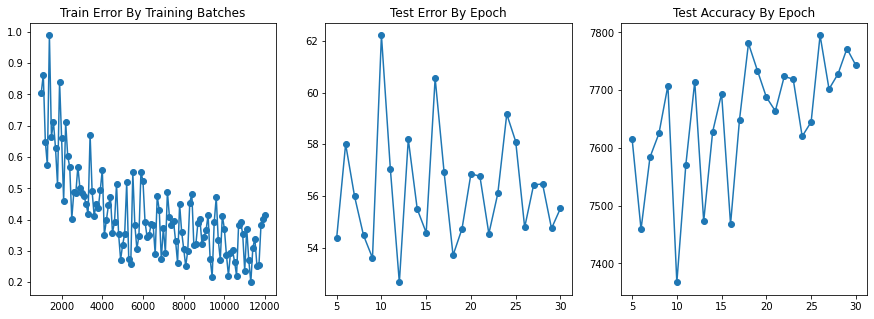

In [45]:
fig, ax = plt.subplots(1,3)
train_batches = [i for i in range(100, 100*(len(train_loss)+1),100)]
test_epochs = [i for i in range(1,len(test_loss)+1)]
ax[0].plot(train_batches[9:], train_loss[9:])
ax[0].scatter(train_batches[9:], train_loss[9:])
ax[0].set_title('Train Error By Training Batches')
ax[1].plot(test_epochs[4:],test_loss[4:])
ax[1].scatter(test_epochs[4:],test_loss[4:])
ax[1].set_title('Test Error By Epoch')
ax[2].plot(test_epochs[4:], test_acc[4:])
ax[2].scatter(test_epochs[4:], test_acc[4:])
ax[2].set_title('Test Accuracy By Epoch')
fig.set_figwidth(15)
fig.set_figheight(5)
plt.show()